<a href="https://colab.research.google.com/github/Aaron-AB/GSOC---LibreHealth/blob/master/PneumoniaModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting drive and declaring libraries

In [2]:
%tensorflow_version 2.x

'''
from google.colab import drive
drive.mount('/content/drive')
'''

import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications

TensorFlow 2.x selected.


Directory and variable declaration

In [0]:
train_dir = '/content/drive/My Drive/chest_xray/train'
test_dir = '/content/drive/My Drive/chest_xray/test'
val_dir = '/content/drive/My Drive/chest_xray/val'

IMG_HEIGHT = 224
IMG_WIDTH = 224
batch = 32
epoch = 15

Size of data. Normal images were augmented and added to the non-augmented training images as there was a significantly larger ratio of Pneumonia to Normal training images. May consider doing more augmentation to keep the ratio equal.

In [4]:
num_tr = len(os.listdir(train_dir + '/NORMAL')) + len(os.listdir(train_dir + '/PNEUMONIA'))
num_va = len(os.listdir(val_dir + '/NORMAL')) + len(os.listdir(val_dir + '/PNEUMONIA'))
print("Number of training images: ", num_tr)
print("Number of test images: ", num_va)
norm_tr = len(os.listdir(train_dir + '/NORMAL'))
pneu_tr = len(os.listdir(train_dir + '/PNEUMONIA'))
print("Number of Normal images: ", norm_tr)
print("Number of Pneumonia images: ", pneu_tr)


Number of training images:  6556
Number of test images:  624
Number of Normal images:  2681
Number of Pneumonia images:  3875


Data Visualization

Normal:


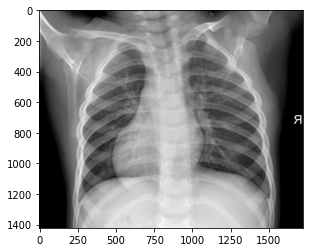

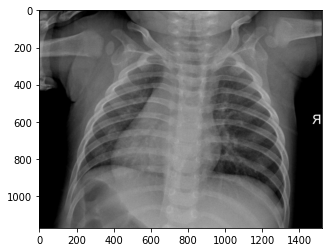

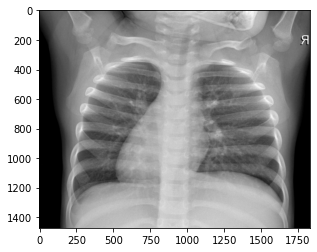

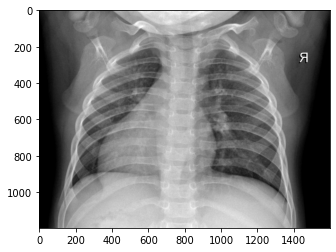

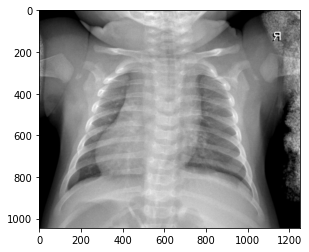

Pneumonia:


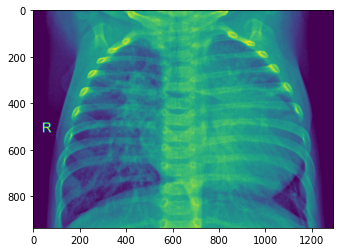

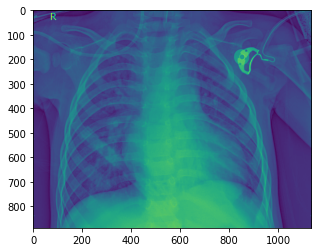

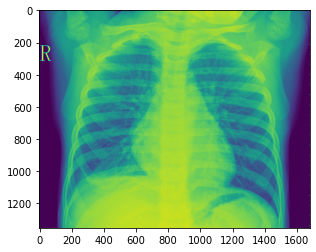

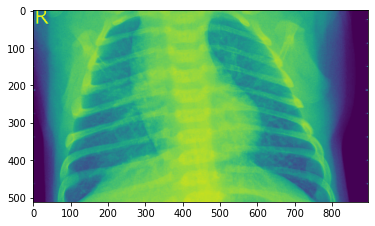

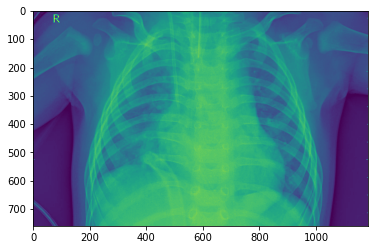

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def loadImages(folder):
    i = 0
    int(i)
    for filename in os.listdir(folder):
      if(i < 5):
        picture=mpimg.imread(folder + '/' + filename)
        imgplot = plt.imshow(picture)
        plt.show()
        i = i + 1
      else:
        return

print("Normal:")
loadImages(train_dir + '/NORMAL')

print("Pneumonia:")
loadImages(train_dir + '/PNEUMONIA')



Creating image data generator

In [6]:
train_batches = ImageDataGenerator(preprocessing_function = applications.mobilenet.preprocess_input).flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH,), batch_size = batch, shuffle = True)

val_batches = ImageDataGenerator(preprocessing_function = applications.mobilenet.preprocess_input).flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH,), batch_size = batch, shuffle = False)


Found 6556 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Model Creation. Transfer learning using mobilenet.

In [0]:
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
x = GlobalAveragePooling2D()(mobile.output)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




Could test with ImageDataGenerator(rescale = 1./255)
Preprocess_input however tends to work better with pre-trained models like mobilenets

In [8]:
model.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=1, verbose=0, mode='auto')],
    epochs=15
)


dir = '/content/drive/My Drive/'
keras_file = "PneumoniaModel"
tf.keras.models.save_model(model, dir+keras_file)
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/My Drive/PneumoniaModel/')
tflite_model = converter.convert()
with open('/content/drive/My Drive/PneumoniaLite.tflite', 'wb') as f:
  f.write(tflite_model)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 205 steps, validate for 20 steps
Epoch 1/15
205/205 [==============================] - 1343s 7s/step - loss: 0.1203 - accuracy: 0.9567 - val_loss: 0.2862 - val_accuracy: 0.8926
Epoch 2/15
205/205 [==============================] - 1226s 6s/step - loss: 0.0132 - accuracy: 0.9966 - val_loss: 0.5981 - val_accuracy: 0.8349
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/PneumoniaModel/assets


0.8349 Validation Accuracy. Will retrain later with different optimization functions. Could also try retraining the last few layers of the model to get the model better fitted for this dataset.

Validation loss and training loss are quite similar for the first epoch so I'll retrain the model with patience set to 0. As a 0.8926 validation accuracy is quite good.

